In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
set_global_seed(42)
# data_path = Path("../data/sat1/split_stage_data.nc")
# data_path = Path("../data/sat1/split_stage_data_100hz.nc")
data_path = Path("../data/sat1/split_stage_data_100hz.nc")
# data_path = Path("../data/sat1/split_stage_data_unprocessed_500hz.nc")

dataset = xr.load_dataset(data_path)

In [4]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(
    dataset, 60, norm_min1_to_1
)
train_acc = train_data.where(train_data.cue == "AC", drop=True)
train_sp = train_data.where(train_data.cue == "SP", drop=True)
val_acc = val_data.where(val_data.cue == "AC", drop=True)
val_sp = val_data.where(val_data.cue == "SP", drop=True)
test_acc = test_data.where(test_data.cue == "AC", drop=True)
test_sp = test_data.where(test_data.cue == "SP", drop=True)

In [5]:
train_dataset = SAT1Dataset(train_acc, shape_topological=shape_topological)
val_dataset = SAT1Dataset(val_acc, shape_topological=shape_topological)
test_dataset = SAT1Dataset(test_acc, shape_topological=shape_topological)
test_sp = SAT1Dataset(test_sp, shape_topological=shape_topological)


In [6]:
model = SAT1GRU(
    len(train_data.channels), len(train_data.samples), len(train_data.labels)
)

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

{'0': {'precision': 0.7770419426048565,
  'recall': 0.7736263736263737,
  'f1-score': 0.775330396475771,
  'support': 455.0},
 '1': {'precision': 0.8688172043010752,
  'recall': 0.8820960698689956,
  'f1-score': 0.875406283856988,
  'support': 458.0},
 '2': {'precision': 0.9223744292237442,
  'recall': 0.8820960698689956,
  'f1-score': 0.9017857142857142,
  'support': 458.0},
 '3': {'precision': 0.9652777777777778,
  'recall': 0.9104803493449781,
  'f1-score': 0.9370786516853933,
  'support': 458.0},
 '4': {'precision': 0.8376753507014028,
  'recall': 0.9126637554585153,
  'f1-score': 0.8735632183908046,
  'support': 458.0},
 'accuracy': 0.8723218189768255,
 'macro avg': {'precision': 0.8742373409217713,
  'recall': 0.8721925236335716,
  'f1-score': 0.8726328529389342,
  'support': 2287.0},
 'weighted avg': {'precision': 0.8743648381648631,
  'recall': 0.8723218189768255,
  'f1-score': 0.8727604906168484,
  'support': 2287.0}}

In [7]:
test_loader = DataLoader(
    test_sp, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

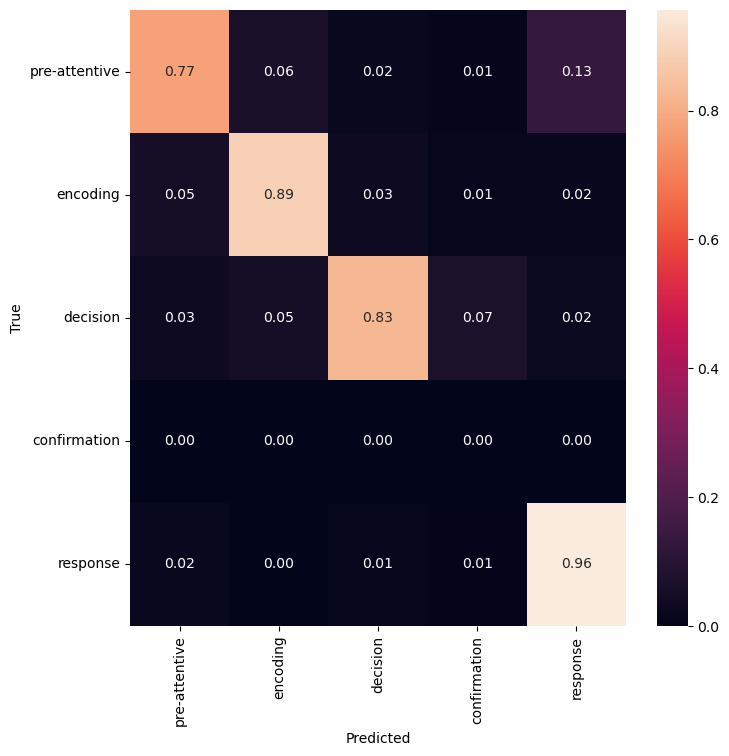

In [8]:
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY)